# Intro to neural networks: Regression

This notebook is based on the SEG Geophysical Tutorial from August 2018 by Graham Ganssle: https://github.com/seg/tutorials-2018.

The idea is to introduce the based components of an artificial neural network and implement a simple version of one using Numpy.

We'll use a regression task — predicting a DT log from other logs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Activation functions

A neural network is nothing but a nonlinear system of equations like $\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$.

There are multiple functions $\sigma$ that are used to introduce the non-linear component. One of the earliest was the *sigmoid* (aka *logistic*) function is given by:

$$ \sigma(z) = \frac{1}{1 + \operatorname{e}^{-z}} $$

Its derivative is:

$$ \frac{\mathrm{d} \sigma(z)}{\mathrm{d} z} = \sigma(z)  (1 - \sigma(z)) $$

We need the derivative for the _backpropagation_ process that enables neural networks to learn efficiently. Backpropagation adjusts the parameters of the neural network by injecting an error signal backwards through the network's layers, from the last to the first.

We can implement the logistic function like this in Python:

In [2]:
def logistic(z, derivative=False):
    if not derivative:
        return 1 / (1 + np.exp(-z))
    else:
        return z * (1 - z)  # In the implementation, 'z' will actually be sigma(z).

The function transforms, or 'squeezes', numbers into the range [0, 1] and looks like this:

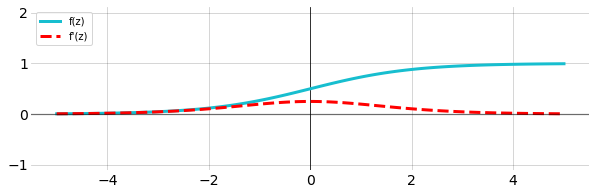

In [3]:
from utils import plot_activation

plot_activation(logistic)

In practice, while this function is sometimes useful for handling probabilities, there are some problems with it.

- The maximum value of the derivative is 0.25, which tends to reduce the learning rate, especially in deeper layers.
- Large activations input result in 'saturation' and a gradient of 0 ('vanishing gradient'), which will halt learning.
- The exponentials are expensive to compute.

The $\operatorname{tanh}$ function solves some of these issues — for example, it has a maximum gradient of 1.

In [4]:
def tanh(z, derivative=False):
    """
    Compute a tanh transformation for a given input.
    """
    if not derivative:
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    else:
        return 1 - z**2  # In the implementation, we'll get tanh(z) coming at us.

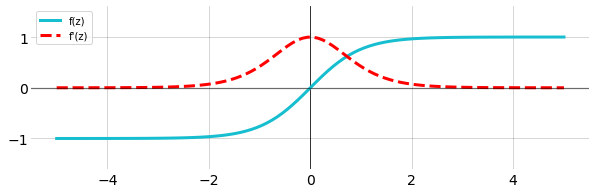

In [5]:
plot_activation(tanh)

But it still suffers from the saturation issue, and the expense of computation.

Both of these issues are solved by the ReLU, or rectified linear unit, function.

### EXERCISE

The **rectified linear unit** (ReLU) and its derivative are given by:

$$ f(z) = \begin{cases}
    z & \text{if } z > 0, \\
    0 & \text{otherwise}.
\end{cases} $$

$$ \frac{\mathrm{d}f(z)}{\mathrm{d}z} = \begin{cases}
    1 & \text{if } z > 0, \\
    0 & \text{otherwise}.
\end{cases} $$

The main problem with the ReLU is that, depending on how the weights are initialized, some units in the network might 'die' as they get into negative activations and never fire. Accordingly, a common variant of the ReLU is the 'parametric' ReLU, which has $f(z) = \alpha z$, when $Z \leq 0$ (the corresponding derivative is then just $\alpha$). The parameter $\alpha$ can be tuned like other hyperparameters. A typical value is 0.01.

The parametric ReLU is also called a 'leaky' ReLU, but that term implies that the value of $\alpha$ is not being considered as a hyperparameter or tuned in any way.

Can you implement a ReLU? (Or, if you prefer, a parametric ReLU?)

In [6]:
# Note that if you use `if z > 0` in your code, then
# the plot_activation function won't work, because it
# defines z as an array to make its plots. In general,
# it's a good idea to write functions that work for
# both scalars and arrays, where possible.

# YOUR CODE HERE



In [7]:
# ReLU solution.
def relu(z, derivative=True):
    """
    Compute a Rectified Linear Unit transformation for a given input.
    """
    if not derivative:
        return z * (z > 0)
    else:
        return 1 * (z > 0)    

In [8]:
# ALTERNATIVE
# Parametric ReLU and a ReLU that builds off it.
def prelu(z, alpha=0.1, derivative=False):
    """
    Compute a Parameter Rectified Linear Unit transformation for a given input.
    """
    if not derivative:
        return np.maximum(alpha * z, z)  # Assumes alpha <= 1.
    else:
        return alpha * (z <= 0) + (z > 0)
    
def relu(z, derivative=False):
    """
    An ordinary ReLU.
    """
    return prelu(z, alpha=0, derivative=derivative)

In [9]:
assert (relu(-1), relu(0), relu(1)) == (0, 0, 1)

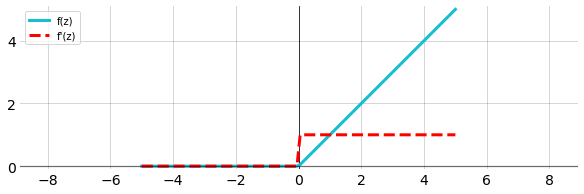

In [10]:
plot_activation(relu)

### Stretch exercise

Some people prefer the exponential linear unit, because it has a smooth derivative. Can you implement it?

$$ f(z) = \begin{cases} z & \text{if } z > 0 \\  \alpha(e^z-1) & \text{otherwise} \end{cases} $$

The derivative is given by:

$$ \frac{\mathrm{d} f}{\mathrm{d} z} = \begin{cases} 1 & \text{if } z > 0 \\  \mathrm{ELU}(z) + \alpha & \text{otherwise} \end{cases} $$

Again, $\alpha$ is a hyperparameter. If you try implementing this, remember that in our code we're going to be dealing with the activation `elu(z)` in the derivative case, not `z` itself. This actually makes it easier to compute!

In [11]:
# YOUR CODE HERE



Check the [Intro_to_neural_network_regression.ipynb](../master/Intro_to_neural_network_regression.ipynb) master notebook for a solution to this problem. 

In [12]:
def elu(z, alpha=0.01, derivative=False):
    """
    ELU using np.where(), which is another way to handle cases.
    """
    if not derivative:
        return np.where(z > 0, z, alpha * (np.exp(z) - 1))
    else:
        return np.where(z > 0, 1, z + alpha)  # Remember, z is actually elu(z).

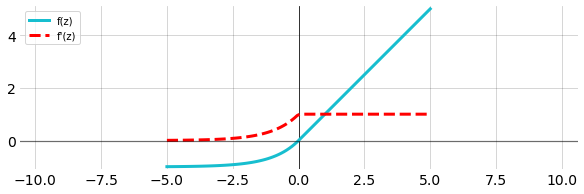

In [16]:
plot_activation(elu, alpha=1.0)

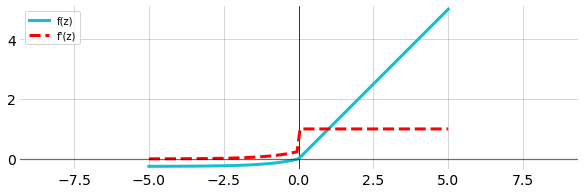

In [17]:
# The derivative for alpha != 1 has a discontinuity though.
plot_activation(elu, alpha=0.25)

There are still other rectifiers — e.g. the GELU and SiLU — read about them [on Wikipedia](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). Why not try implementing some of them?

## Loss

We're going to need a way to tell when we're doing well. The **loss function** is some measure of error. We'll use the mean squared error, where the error is the difference between a known value of the target and our estimate of the target.

We're going to need a function for that too:

In [18]:
def loss(y, y_hat):
    """
    Compute half the mean squared error. The factor of 0.5 gets cancelled by the
    squared term in the derivative, so it's common to see it in the loss function.
    """
    return 0.5 * np.mean((np.array(y_hat) - np.array(y))**2)

## Defining a network

A typical neural network consist of three or more *layers*: an input layer, one or more _hidden_ layers, and an output layer.

Let's implement a network with one hidden layer. The layers are as follows:

$$ \text{Input layer:}\ \ \mathbf{x}^{(i)} $$

$$ \text{Hidden layer:}\ \ \mathbf{a}_1^{(i)} = \sigma ( \mathbf{W}_1 \mathbf{x}^{(i)} + \mathbf{b}_1) $$

$$ \text{Output layer:}\ \ \hat{\mathbf{y}}^{(i)} = \mathbf{W}_2 \mathbf{a}_1^{(i)} + \mathbf{b}_2 $$

where $\mathbf{x}^{(i)}$ is the $i$-th sample of the input data $\mathbf{X}$. $\mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2$ are the weight matrices and bias vectors for layers 1 and 2 respectively, and $\sigma$ is our nonlinear function. Applying the nonlinearity to $\mathbf{W}_1 \mathbf{x}^{(i)} + \mathbf{b}_1$ in layer 1 results in the _activation_ $\mathbf{a}_1$. The output layer yields $\hat{\mathbf{y}}^{(i)}$, the $i$-th estimate of the desired output. We're not going to apply the nonlinearity to the output, but people often do. The weights are randomly initialized and the biases start at zero; during training they will be iteratively updated to encourage the network to converge on an optimal approximation to the expected output.


Note that these are vector operations. In `Numpy` we can easily deal with this because the library understands proper matrix operations. For example, matrix multiplication is done through the `@` operator.

A forward pass of the data through the network looks like this:

In [19]:
def forward(xi, W1, b1, W2, b2, activation):
    z1 = W1 @ xi + b1
    a1 = activation(z1)
    z2 = W2 @ a1 + b2  # n.b. z2 is y_hat
    return z2, a1

Below is a picture of a neural network similar to the one we're building:

![image](../images/figure_1.png)

## How does a neural net learn?

The short version is that we show the system a bunch of corresponding input/output pairs we want it to learn, and we show it these pairs thousands of times. Every time we do so, we move the **W**'s and **b**'s in whatever direction makes the outputs of the network more similar to the known output we're trying to teach it. 

    For each training example:
        For each layer:
          - Calculate the error.
          - Calculate weight gradient.
          - Update weights.
          - Calculate the bias gradient.
          - Update biases.

What's all this about gradients?

In order to learn, the network will have to find the parameters (weights and biases) that result in the smallest loss. We'll use gradient descent for this. 

<img src="../images/gradient_descent.png" width="800px" />

This is straightforward for the output layer. That's why we needed the derivative in the activation functions, and we need to know the derivative for the `loss()` function.

The error on the output layer for a given instance (data record) looks like this:

$$ E = \frac{1}{2} \left[ \hat{y}^{(i)} - y^{(i)} \right]^2 $$

where

$$ \hat{y}^{(i)} = \mathbf{w}_2 \mathbf{a}_1^{(i)} + b_2 $$

The derivative (gradient, or slope) of this function, with respect to the weight **w**<sub>2</sub>, is:

$$ \frac{\mathrm{d}E}{\mathrm{d}\mathbf{w_2}} =  \frac{\mathrm{d}E}{\mathrm{d}\hat{y}}\frac{\mathrm{d}\hat{y}}{\mathrm{d}\mathbf{w_2}} = (\hat{y} - y) \ \mathbf{a}_1$$

To calculate the gradient at the hidden layer, we need to compute the gradient of the error with respect to the weights and biases of the hidden layer.

Let's implement this as a Python function:

In [20]:
def backward(xi, yi,
             a1, z2,
             params,
             learning_rate,
             activation
            ):

    err_output = z2 - yi  # Derivative of loss function
    grad_W2 = err_output * a1
    params['W2'] -= learning_rate * grad_W2

    grad_b2 = err_output
    params['b2'] -= learning_rate * grad_b2

    derivative = activation(a1, derivative=True)
    err_hidden = err_output * derivative * params['W2']
    grad_W1 = err_hidden[:, None] @ xi[None, :]
    params['W1'] -= learning_rate * grad_W1
    
    grad_b1 = err_hidden
    params['b1'] -= learning_rate * grad_b1
    
    return params

The trick with the `None` indexing is the same as reshaping the array. We have to do this to produce a 2D array for the `W1` gradients.

To demonstrate this backpropagation workflow, and thus that our system can learn, let's try to get the above neural network to learn the relationship between a sonic log and some other logs. We're going to need some data.

## Get some data

We'll try using R-39 from offshore Nova Scotia.

In [33]:
import welly

w = welly.Well.from_las('https://geocomp.s3.amazonaws.com/data/R-90.las', index='original')

data, depth = w.data_as_matrix(keys=['GR', 'NPHISS', 'RHOB', 'DT'],
                               start=1000, stop=3500, step=0.2,
                               return_basis=True)

vals = slice(6500, 6750)
trns = slice(6750, 7750)

In [34]:
import welly
import numpy as np

w = welly.Well.from_las('https://geocomp.s3.amazonaws.com/data/R-39.las', index='original')
w

Well(uwi: '303N764340060300', 22 curves: ['BS', 'CALI', 'CHR1', 'CHR2', 'CHRP', 'CHRS', 'DRHO', 'DT1R', 'DT2', 'DT2R', 'DT4P', 'DT4S', 'GR', 'HD1', 'HD2', 'HD3', 'NPOR', 'PEF', 'RHOB', 'SPR1', 'TENS', 'VPVS'])

As you see, there is plenty of data in this well, in case you want to try using more logs later &mdash; e.g. to see if you can improve the prediction.

For now we're going to select 3 logs from which to predict DTS.

In [45]:
dts = w.data['DT4S']
dts[dts < 0] = np.nan
w.data['DT4S'] = dts.interpolate()

data, depth = w.data_as_matrix(keys=['GR', 'DT4P', 'RHOB', 'DT4S'],
                               start=2200, stop=3300, step=0.2,
                               return_basis=True)

vals = slice(None, 250)
trns = slice(250, 1250)

In [46]:
data[:10]

array([[  79.5942479 ,  320.88848609, 2450.88606325,  585.71543478],
       [  77.1786594 ,  320.17862888, 2439.61139471,  585.48897907],
       [  78.28969473,  316.87019083, 2430.86070497,  585.26252336],
       [  81.97081353,  317.3122801 , 2429.15074206,  585.03606765],
       [  86.85707746,  316.53112952, 2438.99183615,  584.80961194],
       [  89.95770652,  317.53366754, 2448.38971497,  584.58315623],
       [  88.07161574,  318.47312116, 2441.11450765,  584.35670052],
       [  84.1502988 ,  317.8514316 , 2442.09380521,  584.13024481],
       [  78.46198086,  314.97805046, 2449.70014404,  583.9037891 ],
       [  79.23050785,  310.36472082, 2465.89842501,  583.67733339]])

In [57]:
from sklearn.preprocessing import StandardScaler

z_train = depth[trns]
z_val = depth[vals]

X_train = data[trns, :3]
X_val = data[vals, :3]

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [58]:
X_train.shape, X_val.shape

((1000, 3), (250, 3))

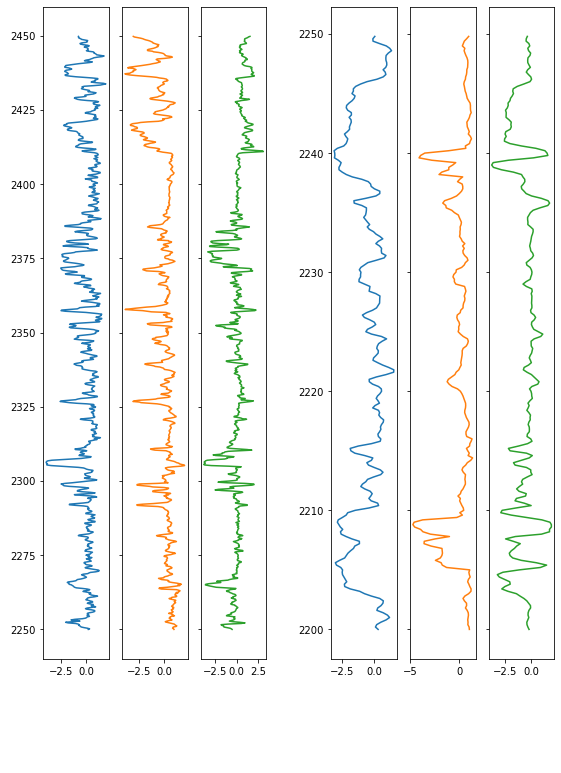

In [83]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8, 12))
fig_train, fig_val = fig.subfigures(ncols=2)

for ax, log, c in zip(fig_train.subplots(ncols=3, sharey=True),
                      X_train.T, ['C0', 'C1', 'C2']):
    ax.plot(log, z_train, c=c)
    
for ax, log, c in zip(fig_val.subplots(ncols=3, sharey=True),
                   X_val.T, ['C0', 'C1', 'C2']):
    ax.plot(log, z_val, c=c)

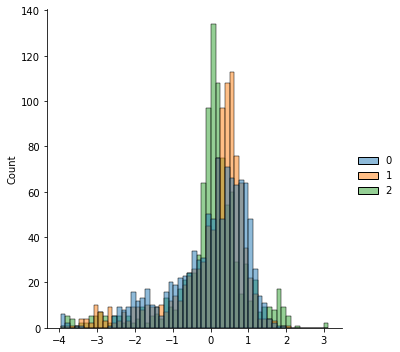

In [60]:
import seaborn as sns

sns.displot(X_train)

In many situations, we do not need to scale the target variable. But when using gradient descent for optimization — essentially in all neural nets — we might need to worry about it. 

Very large errors may lead to exploding gradients in training and/or result in floating point overflows — especially if you're using GPUs, which use single-precision floats.

In [41]:
y_val_ = data[vals, -1]    # Keep the unscaled data.
y_train_ = data[trns, -1]

target_scaler = StandardScaler().fit(y_train_.reshape(-1, 1))

y_train = target_scaler.transform(y_train_.reshape(-1, 1)).ravel()
y_val = target_scaler.transform(y_val_.reshape(-1, 1)).ravel()

In [42]:
X_train.shape, y_train.shape

((1000, 3), (1000,))

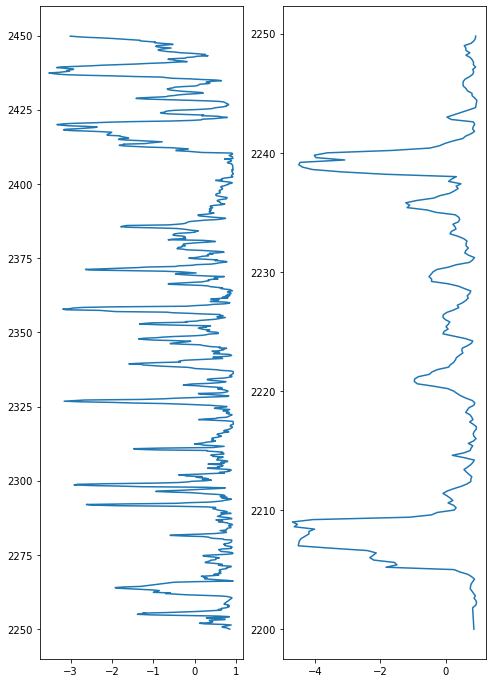

In [86]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 12))

ax0.plot(y_train, z_train)
ax1.plot(y_val, z_val)

## Initialize network parameters

Now we can initialize the weights and biases for our network. A common approach is to initialize the weights with small random numbers (with NumPy's `randn()` function) and the biases with zeros.

### EXERCISE

Finish the `initialize_params()` function:

In [27]:
def initialize_params(features, units, seed=42):
    np.random.seed(seed)
    params = {
        "W1": 0.1 * np.random.randn(units, features),
        "b1": np.zeros(shape=units),

        # YOUR CODE HERE
        # Initialize W2 (shape is just `units`) and b2 (shape is `1`)
        
        
        # ===============
    }
    return params

In [28]:
def initialize_params(features, units, seed=42):
    np.random.seed(seed)
    params = {
        "W1": np.random.randn(units, features),
        "b1": np.zeros(shape=units),

        "W2": np.random.randn(units),
        "b2": np.zeros(shape=1)
    }
    return params

In [29]:
features = X_train.shape[-1]
units = 5  # Units in hidden layer.

params = initialize_params(features, units)

In [30]:
params

{'W1': array([[ 0.49671415, -0.1382643 ,  0.64768854],
        [ 1.52302986, -0.23415337, -0.23413696],
        [ 1.57921282,  0.76743473, -0.46947439],
        [ 0.54256004, -0.46341769, -0.46572975],
        [ 0.24196227, -1.91328024, -1.72491783]]),
 'b1': array([0., 0., 0., 0., 0.]),
 'W2': array([-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ]),
 'b2': array([0.])}

Now we have a network! It just doesn't know anything.

## Prediction

To apply this (untrained) network to some data, we're going to need a `predict` function, to make inferences from the trained network. This mode of application is called **inference**.

### EXERCISE

Finish the `predict()` function.

In [31]:
def predict(X, forward, params, activation):
    """
    Make a prediction for a given 2D input ``X``,
    using function ``forward``.
    """
    y_hats = []
    for xi in X:
        # YOUR CODE HERE
        # You need to call `forward` to set a value for `y_hat`.
        
        # ==============
        y_hats.append(y_hat.item())
    return np.array(y_hats)

In [32]:
def predict(X, forward, params, activation):
    """
    Make a prediction for a given 2D input ``X``,
    using function ``forward``.
    """
    y_hats = []
    for xi in X:
        y_hat, _ = forward(xi, **params, activation=activation)
        y_hats.append(y_hat.item())
    return np.array(y_hats)

Let's make a prediction for our untrained network — it should be essentially random:

In [33]:
y_pred = predict(X_train, forward, params, activation=relu)

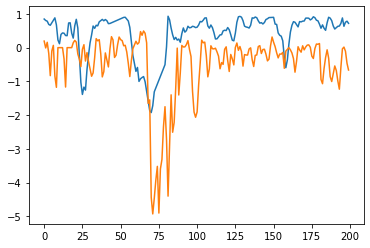

In [34]:
plt.plot(y_train[:200])
plt.plot(y_pred[:200])

## Training

During training, we expose the network to the input/output pairs one at a time. These pairs are called `xi` and `yi` respectively in the code. According to our diagram above, the input goes into the green slots and we adjust the orange neurons to make the red slot output from the network a tiny bit closer to the true DT result.

We do this many times. Every time we do, we calculate the mean squared error between the network's prediction and the ground-truth output. After many iterations, or *epochs*, we draw a plot which shows the total error, or loss, at each step. If the network is learning anything, we expect the loss to decrease, as the predictions are getting closer to the ground truth.

In [35]:
# Hyperparameters.
num_epochs = 100
learning_rate = 0.01
activation = relu

# Initialize.
data = list(zip(X_train, y_train, y_train_))
params = initialize_params(features, units)
loss_history = []

for i in tqdm(range(num_epochs)):

    # Shuffle and prepare.
    np.random.shuffle(data)
    y_, y_hat = [], []
    
    for xi, yi, y_raw in data:
        
        # Optionally do a pass for validation (omitted here).
        
        # Forward pass.
        z2, a1 = forward(xi, **params, activation=activation)

        # Back propagation.
        params = backward(xi, yi,
                          a1, z2.item(),
                          params,
                          learning_rate,
                          activation=activation
                         )
        
        # Capture actual prediction at correct scale.
        y_.append(y_raw)
        y_hat.append(target_scaler.inverse_transform(z2))

    # Compute training loss for this epoch.
    loss_history.append(loss(y_, y_hat))

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.86it/s]


The parameters of the model are now no longer random.

In [36]:
params

{'W1': array([[-0.32527054, -0.76454353,  0.60771137],
        [ 1.34486527,  1.19084254, -1.11263352],
        [ 1.9873282 ,  1.55586449, -0.2179226 ],
        [ 0.36074414, -0.17123815, -0.22460322],
        [-0.30563499, -2.93486096,  0.25908304]]),
 'b1': array([ 0.34253317,  0.27858228,  0.69509516, -0.48357831,  1.88943021]),
 'W2': array([ 0.11867662, -0.26600815,  0.17097152, -0.6941399 , -0.38089063]),
 'b2': array([0.74630247])}

They do look kind of random though. It's usually hard to 'see' what neural networks have learned. Let's look at the W1 weights only:

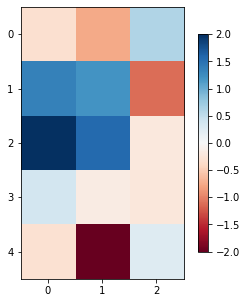

In [37]:
W1 = params['W1']

plt.figure(figsize=(5, 5))
plt.imshow(W1, cmap='RdBu', vmin=-2, vmax=2)
plt.colorbar(shrink=0.8)
_ = plt.yticks([0, 1, 2, 3, 4])

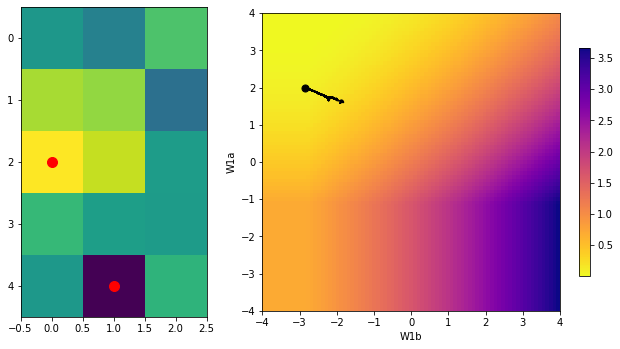

In [38]:
# Visualize the loss surface with respect to two of the W1 params.
# Using the last values of xi, and yi from the loop.
from copy import deepcopy

# Prepare to capture weights.
w1a_loc, w1b_loc = np.s_[2, 0], np.s_[4, 1]
w1as, w1bs = [], []

data = list(zip(X_train, y_train, y_train_))
params_ = initialize_params(features, units, seed=42)
for i in range(num_epochs):
    np.random.seed(9)
    np.random.shuffle(data)
    for xi, yi, y_raw in data:
        z2, a1 = forward(xi, **params_, activation=activation)
        params_ = backward(xi, yi, a1, z2.item(),
                           params_, learning_rate,
                           activation=activation)
        # Capture params.
        w1as.append(params_['W1'][w1a_loc])
        w1bs.append(params_['W1'][w1b_loc])
    
# This is clunky because our network is not vectorized.
params__ = deepcopy(params_)  # Freeze.
r = 4
theta = np.zeros((20*r+1, 20*r+1))
for i, w1a in enumerate(np.arange(-r, r+.001, 0.1)):
    for j, w1b in enumerate(np.arange(-r, r+.001, 0.1)):
        params__['W1'][w1a_loc] = w1a
        params__['W1'][w1b_loc] = w1b
        z2, a1 = forward(xi, **params__, activation=activation)
        theta[i, j] = (z2 - yi)**2  # Just care about shape of error.
        
# Plot the cost surface and our path across it.
gskw = {'width_ratios': (1, 2)}
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(11, 7), gridspec_kw=gskw)
ax0.imshow(params['W1'])
ax0.scatter(w1b_loc[1], w1b_loc[0], c='red', s=100)
ax0.scatter(w1a_loc[1], w1a_loc[0], c='red', s=100)
im = ax1.imshow(theta, cmap='plasma_r', origin='lower', extent=(-r, r, -r, r))
ax1.plot(w1bs, w1as, c='k')
ax1.scatter(params_['W1'][w1b_loc], params_['W1'][w1a_loc], c='k', s=50)
plt.colorbar(im, shrink=0.6)
ax1.set_xlabel(f'W1b')
ax1.set_ylabel(f'W1a')
plt.show()

If the network learned anything **useful** then the loss should have decreased during training. The loss is our measure of whatever it is we care about.

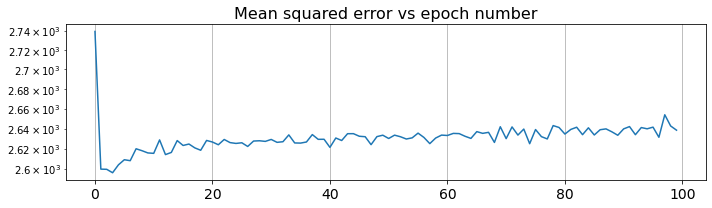

In [98]:
fig, ax = plt.subplots(figsize=(10,3))

ax.semilogy(loss_history, label='Training loss')

ax.set_title('Mean squared error vs epoch number', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()

plt.tight_layout()
plt.show()

In [99]:
y_pred = predict(X_val, forward, params, activation)

The loss decreased dramatically over the course of relatively few epochs, so presumably the network has learned something. To test this theory, let's plot the outputs after training (orange) and compare them to the expected result (blue):

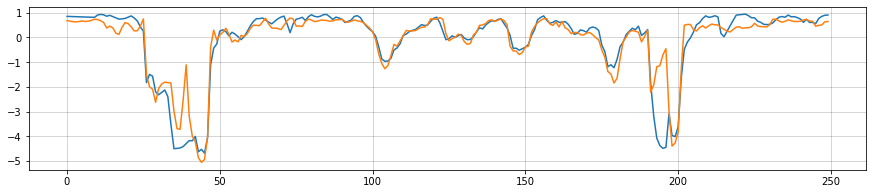

In [100]:
plt.figure(figsize=(15, 3))
plt.plot(y_val)
plt.plot(y_pred)
plt.grid(c='k', alpha=0.2)

## Compare using RMS error

It's fine for the network to learn using MSE, but it's easier for humans to understand RMS error, because it has the same units as the target.

### EXERCISE

Implement an equation for the RMS error.

$$ E_\mathrm{RMS} = \sqrt{ \frac{1}{N} \sum_{i=0}^{N} (\hat{y} - y)^2 } $$

In [101]:
def rmse(y_true, y_pred):

    # YOUR CODE HERE
    
    return rmse

In [163]:
def rmse(y_true, y_pred):
    """
    Compute the square root of the mean squared error for a 1D array.
    """
    mse = np.sum((y_pred - y_true)**2) / y_true.size
    return np.sqrt(mse)

In [103]:
rmse(y_val_, target_scaler.inverse_transform(y_pred))

31.40493248401497

## Exercise: how does this network look in `scikit-learn`?

Replicate this neural network with `sklearn.neural_network.MLPRegressor`.

You will have to read the documentation carefully. In particular, pay attention to `solver`, `activation`, `max_iter`, and `batch_size`.

Get started with this:

In [104]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(5,),
                   tol=1e-12,   # Turn off early stopping.
                   momentum=0,  # Turn off momentum                   
                   
                   # YOUR CODE HERE
                   
                  )

mlp.fit(X_train, y_train)

y_pred_skl = mlp.predict(X_val)

/home/matt/miniconda3/envs/geoml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


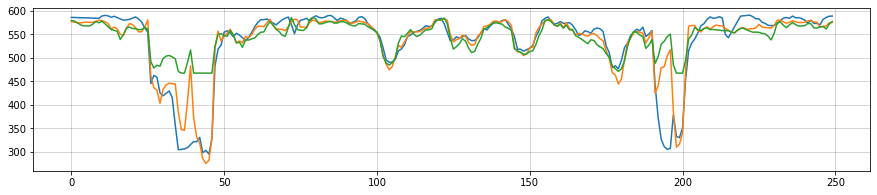

In [105]:
plt.figure(figsize=(15, 3))
plt.plot(y_val_)
plt.plot(target_scaler.inverse_transform(y_pred))
plt.plot(target_scaler.inverse_transform(y_pred_skl))
plt.grid(c='k', alpha=0.2)

In [106]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(5,),
                   activation='relu',
                   alpha=0,       # No regularization.
                   solver='sgd',  # Default is 'adam'.
                   learning_rate_init=0.01,   # Default is 0.001.
                   learning_rate='constant',   # Default.
                   batch_size=1,  # Slow. Default is min(200, data length)
                   max_iter=num_epochs,
                   momentum=0,    # Turn off momentum
                  )

mlp.fit(X_train, y_train)

y_pred_skl = mlp.predict(X_val)

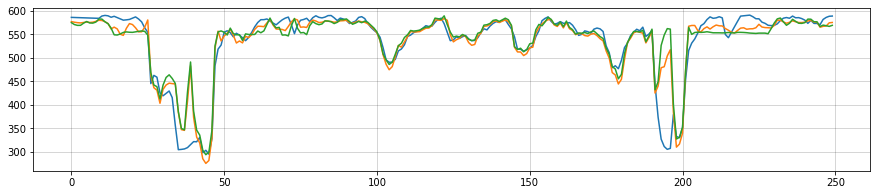

In [107]:
plt.figure(figsize=(15, 3))
plt.plot(y_val_)
plt.plot(target_scaler.inverse_transform(y_pred))
plt.plot(target_scaler.inverse_transform(y_pred_skl))
plt.grid(c='k', alpha=0.2)

In [172]:
print("Scratch NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred)))
print()
print("Sklearn NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred_skl)))

Scratch NN
32.171329250720035

Sklearn NN
35.0507704872433


### EXERCISE

Can you change the hyperparameters to get a better result?

In [173]:
# Copy the solution from the last example here.
# Then change some of the parameters and see how it affects the result.

In [174]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(20,),
                   activation='relu',
                   alpha=0.001,
                   solver='adam',
                   learning_rate_init=0.01,
                   learning_rate='constant',
                   batch_size=200,
                   max_iter=1000,
                   momentum=0.9,
                  )

mlp.fit(X_train, y_train)

y_pred_skl = mlp.predict(X_val)

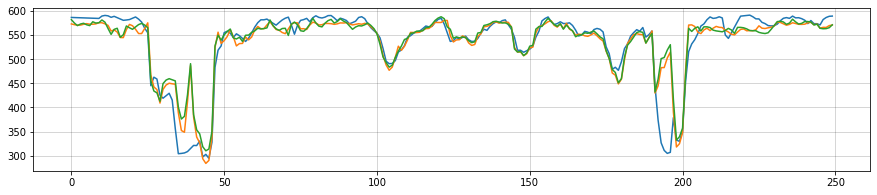

In [175]:
plt.figure(figsize=(15, 3))
plt.plot(y_val_)
plt.plot(target_scaler.inverse_transform(y_pred))
plt.plot(target_scaler.inverse_transform(y_pred_skl))
plt.grid(c='k', alpha=0.2)

In [176]:
print("Scratch NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred)))
print()
print("Sklearn NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred_skl)))

Scratch NN
32.171329250720035

Sklearn NN
34.8952461482109


## Compare with PyTorch

In [177]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [178]:
X_train_pt = torch.tensor(X_train, dtype=torch.float32).to(device) 
y_train_pt = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)

traindata = torch.utils.data.TensorDataset(X_train_pt, y_train_pt)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=20, shuffle=True)

There's a high-level approach:

In [179]:
net = nn.Sequential(
    nn.Linear(3, 5),
    nn.ELU(), 
    nn.Linear(5, 1),
).to(device)

And a low-level approach that gives you fine-tuned control:

In [180]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(3, 5)  # Applies z = Wx + b.
        self.output = nn.Linear(5, 1)

        # Optional.
        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        z1 = self.hidden(x)
        a1 = torch.nn.functional.elu(z1)
        z2 = self.output(a1)
        return z2
    
net = Net().to(device)

Training the network:

In [181]:
lr = 0.01
weight_decay = 0.0  # L2 regularization
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.MSELoss()

net.train()

epochs = 30
for epoch in range(epochs):
    epoch_loss = 0.0
    for xi, yi in trainloader:
        optimizer.zero_grad()
        y_hat = net(xi)
        loss_ = criterion(y_hat, yi)
        loss_.backward()
        optimizer.step()
        epoch_loss += loss_.item()
    print(f"# {epoch+1}  Loss {epoch_loss}")
print('Finished training')

# 1  Loss 12.131571404635906
# 2  Loss 9.496902767568827
# 3  Loss 8.55759784579277
# 4  Loss 7.938823502510786
# 5  Loss 7.453101184219122
# 6  Loss 7.063187416642904
# 7  Loss 6.757320918142796
# 8  Loss 6.51916797272861
# 9  Loss 6.32234837859869
# 10  Loss 6.173643849790096
# 11  Loss 6.0651791505515575
# 12  Loss 5.966006802394986
# 13  Loss 5.888506570830941
# 14  Loss 5.831425966694951
# 15  Loss 5.785718673840165
# 16  Loss 5.750142976641655
# 17  Loss 5.715989962220192
# 18  Loss 5.6979870945215225
# 19  Loss 5.678116263821721
# 20  Loss 5.664167942479253
# 21  Loss 5.647649068385363
# 22  Loss 5.635611739009619
# 23  Loss 5.621447494253516
# 24  Loss 5.611205095425248
# 25  Loss 5.603663129732013
# 26  Loss 5.59403121471405
# 27  Loss 5.592323113232851
# 28  Loss 5.585575854405761
# 29  Loss 5.568256651982665
# 30  Loss 5.570291167125106
Finished training


### Evaluate the model

In [182]:
X_val_pt = torch.tensor(X_val, dtype=torch.float).to(device)
y_val_pt = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float).to(device)

valdata = torch.utils.data.TensorDataset(X_val_pt, y_val_pt)
valloader = torch.utils.data.DataLoader(valdata)

In [183]:
net.eval()

with torch.no_grad():
    y_pred_torch = [float(net(xi)) for xi, yi in valloader]

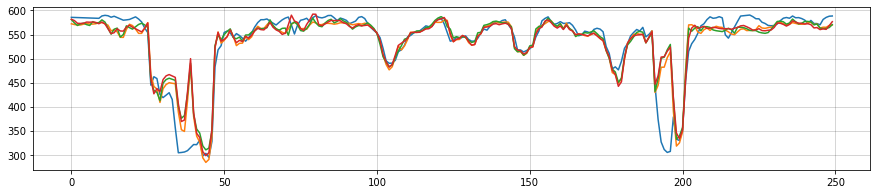

In [184]:
plt.figure(figsize=(15, 3))
plt.plot(y_val_)
plt.plot(target_scaler.inverse_transform(y_pred))
plt.plot(target_scaler.inverse_transform(y_pred_skl))
plt.plot(target_scaler.inverse_transform(y_pred_torch))
plt.grid(c='k', alpha=0.2)

In [185]:
print("Scratch NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred)))
print()
print("Sklearn NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred_skl)))
print()
print("PyTorch NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred_torch)))

Scratch NN
32.171329250720035

Sklearn NN
34.8952461482109

PyTorch NN
35.08965342097318


### Saving a PyTorch model

It is possible to save the mode with `torch.save(model, PATH)`, but this is not recommended because it depends on the exact structure of the project (files, directories, etc). Instead, PyTorch docs recommend saving the model class 

We can save the model's parameters to disk:

In [141]:
# For Dataiku users.
# import dataiku
# import os

# path = dataiku.Folder('geocomp').get_path()
# os.chdir(os.join(path, 'notebooks'))

In [142]:
fname = "dt_model.pth"
torch.save(net.state_dict(), fname)

...and read them into a new model:

In [143]:
saved_net = Net()
saved_net.load_state_dict(torch.load(fname))

saved_net.to(device)
saved_net.eval()

with torch.no_grad():
    y_pred_torch_ = [float(saved_net(xi)) for xi, yi in valloader]

# Check it's the same as before.
np.all(y_pred_torch == y_pred_torch_)

True

## Compare with linear regression

### EXERCISE

Make a prediction using `sklearn.linear_model.Ridge`. How does it compare to the neural networks?

In [77]:
from sklearn.linear_model import Ridge

# YOUR CODE HERE

# End with...
y_pred_linreg = 

SyntaxError: invalid syntax (870740926.py, line 6)

In [144]:
from sklearn.linear_model import Ridge

regr = Ridge()

regr.fit(X_train, y_train_)  # Don't need to scale y.

y_pred_linreg = regr.predict(X_val)

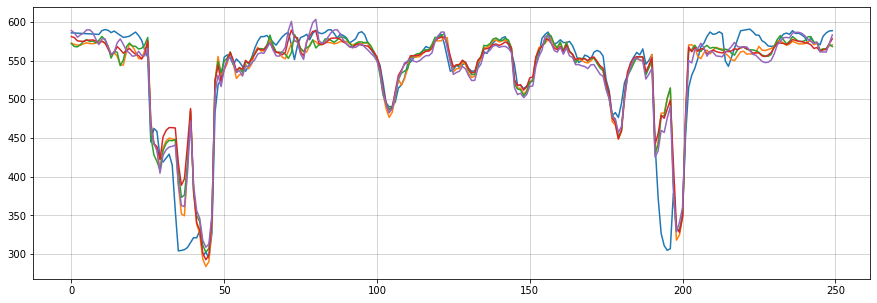

In [145]:
plt.figure(figsize=(15, 5))
plt.plot(y_val_)
plt.plot(target_scaler.inverse_transform(y_pred))
plt.plot(target_scaler.inverse_transform(y_pred_skl))
plt.plot(target_scaler.inverse_transform(y_pred_torch))
plt.plot(y_pred_linreg)
plt.grid(c='k', alpha=0.2)

In [146]:
print("Scratch NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred)))
print()
print("Sklearn NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred_skl)))
print()
print("PyTorch NN")
print(rmse(y_val_, target_scaler.inverse_transform(y_pred_torch)))
print()
print("Linear regression")
print(rmse(y_val_, y_pred_linreg))

Scratch NN
32.18078146018699

Sklearn NN
32.18014474569553

PyTorch NN
32.89043115446235

Linear regression
29.461644514859497


---

## Optional exercises

Try to do these exercises on the NumPy implementation. But if that proves too difficult, use the `sklearn` implementation.

- Try changing the model parameters, for example using fewer units in the hidden layer. Does this help?
- Add another layer to the model. Does this help?
- Add validation to the NumPy and/or PyTorch models as part of the training loop.
- Try using other activation functions than the logistic function we're currently using.
- Try [other initialization strategies](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79).
- Implement batches, RMSprop, dropout, or momentum.

### Stretch

If you've taken the Mastery class, or know about object oriented programming, write a Python `class` to hold the NumPy implementation. Copy the `keras`/`sklearn` interface as closely as possible. Related: [this awesome video from Joel Grus](https://www.youtube.com/watch?v=o64FV-ez6Gw).

## Other types of neural networks

![image](../images/nn_arch_cheatsheet.png)

---

&copy; 2021 Agile Scientific and Graham Ganssle — Content is CC-BY-SA